# Ames Housing Data and Kaggle Challenge

### Part 3A: MLR

For this section, I am going to try several models that increase in complexity. These are all models that I created to eventually submit to Kaggle so the goal was minimizing the RSME. The model I used to create my presentation is in the notebook "05.Presentation Model and Plots' where the goal was more interpretation focused.
<br>
<br>[Model #1](#Model-1) only with numerical data that is strongly correlated with the price
<br>[Model #2](#Model-2) with a few dummies and interactions
<br>[Model #3](#Model-3) with a few more dummies and interactions
<br>[Model #4](#Model-4) with log (1st submission to Kaggle)
<br>[Model #5](#Model-5) with a few more interactions and log (2nd submission to Kaggle)
<br>[Model #6](#Model-6) with a few more interactions and log (3rd submission to Kaggle)
<br>[Model #7](#Model-7) attempt to get back to the basics (4th submission to Kaggle)

NOTE: For pretty much all of these models, I engineered several features that I have since removed because they showed no significance (i.e. p-value was above .05). Since they weren't in use, I have removed some those features to clean up the notebook but wanted to leave this note as that trial and error was part of my process.

First, I'll import all the neccessary packages:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn import metrics
import pickle
import statsmodels.api as sm

I'm also creating a custom functin that finds metrics so I can quickly evaluate each version on my model:

In [2]:
def find_metrics(xtrain, ytrain, xtest, ytest, model, model_pred):
    mean_2_error = metrics.mean_squared_error(ytrain, model_pred)
    mean_ab_error = metrics.mean_absolute_error(ytrain, model_pred)
    rmse = mean_2_error **.5
    r2_test = model.score(xtrain, ytrain)
    r2_train = model.score(xtest, ytest)
    r2_cv = cross_val_score(model, xtrain, ytrain).mean()
    return f'MSE: {mean_2_error}, RMSE: {rmse}, MAE : {mean_ab_error}, R2-Train : {r2_test}, R2-Test: {r2_train}, R2 Cross Val: {r2_cv}' 

In [3]:
def find_metrics_2(xtrain, ytrain, xtest, ytest, model, model_pred):
    mean_2_error = metrics.mean_squared_error(ytrain, model_pred)
    mean_ab_error = metrics.mean_absolute_error(ytrain, model_pred)
    rmse = mean_2_error **.5
    return f'MSE: {mean_2_error}, RMSE: {rmse}, MAE : {mean_ab_error}' 

Reading in my data:

In [4]:
ames = pd.read_csv('../datasets/ames_housing_cleaned.csv')

In [5]:
ames.head()

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,13517,Pave,IR1,Lvl,AllPub,CulDSac,...,44,0,0,0,0,0,3,2010,WD,130500
1,544,531379050,60,RL,11492,Pave,IR1,Lvl,AllPub,CulDSac,...,74,0,0,0,0,0,4,2009,WD,220000
2,153,535304180,20,RL,7922,Pave,Reg,Lvl,AllPub,Inside,...,52,0,0,0,0,0,1,2010,WD,109000
3,318,916386060,60,RL,9802,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,4,2010,WD,174000
4,255,906425045,50,RL,14235,Pave,IR1,Lvl,AllPub,Inside,...,59,0,0,0,0,0,3,2010,WD,138500


# Model 1

For my first model, I'm going to engineer one really simple feature which combines all the different types of bathrooms into a total count:

In [6]:
ames['total_bath'] = ames['bsmt_full_bath'] + (ames['bsmt_half_bath'] *.5) + ames['full_bath'] + (ames['half_bath'] *.5)


In [7]:
ames.head()

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice,total_bath
0,109,533352170,60,RL,13517,Pave,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,0,3,2010,WD,130500,2.5
1,544,531379050,60,RL,11492,Pave,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,0,4,2009,WD,220000,3.5
2,153,535304180,20,RL,7922,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,1,2010,WD,109000,2.0
3,318,916386060,60,RL,9802,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,4,2010,WD,174000,2.5
4,255,906425045,50,RL,14235,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,3,2010,WD,138500,2.0


For the features on this model, I'm going to simply include columns that are already numeric, ordered, and showed a strong positive correlation with price in my EDA:

Building Model #1:

In [8]:
features_1 = ['overall_qual', 'gr_liv_area', 'garage_cars', 'garage_area', '1st_flr_sf', 'total_bsmt_sf', 'year_built', 'total_bath', 'year_remod/add', 'totrms_abvgrd', 'mas_vnr_area']

In [9]:
X_1 = ames[features_1]
y_1 = ames['saleprice']

Dividing the data into train/test sets:

In [10]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, random_state = 21)

Instantiating and fitting my model:

In [11]:
model_1 = LinearRegression()

In [12]:
model_1.fit(X_1_train, y_1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Making predictions and visualizing against the actual sale price:

In [13]:
y_pred_1 = model_1.predict(X_1_train)

Text(0, 0.5, 'Actual Price')

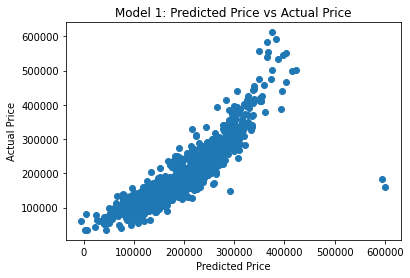

In [14]:
plt.scatter(y_pred_1, y_1_train)
plt.title('Model 1: Predicted Price vs Actual Price')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')

Calculating the metrics on this model with my functions:

In [15]:
find_metrics(X_1_train, y_1_train, X_1_test, y_1_test, model_1, y_pred_1)

'MSE: 1332562809.029898, RMSE: 36504.28480370349, MAE : 23787.01882909565, R2-Train : 0.784796653563961, R2-Test: 0.8293117353837484, R2 Cross Val: 0.7662361185395674'

**Model 1 Conclusion**:  The R2 scores of the train, test, and cross val are all relatively close. Because they aren't too far from each other, I think this is a solid place to start, these are the scores to beat in my next models.

## Model 2

For the second model, I'm going to build on my previous model by including cateogorical data with dummies.

Because location is such an important part of real estate, I want to find a way to incorporate that into my model. To do this, I'm goign to incorporate Neighborhoods. Rather than create a separate dummy coulmn for each neighborhood, I'm going to create one column that has a dummy value related to the average home price in that area.

These are the averages I'll create my dummy values off of.

In [16]:
neighbor_avg = ames.groupby(ames['neighborhood'])['saleprice'].mean()

In [17]:
print(neighbor_avg)

neighborhood
Blmngtn    200417.681818
Blueste    144566.666667
BrDale     103371.052632
BrkSide    128857.094595
ClearCr    220684.615385
CollgCr    202359.544944
Crawfor    205976.600000
Edwards    131576.503937
Gilbert    188947.618182
Greens     188666.666667
GrnHill    330000.000000
IDOTRR     104439.571429
Landmrk    137000.000000
MeadowV    100231.250000
Mitchel    170645.512821
NAmes      147701.682274
NPkVill    140476.470588
NWAmes     194619.022989
NoRidge    316294.125000
NridgHt    321783.966387
OldTown    126439.158228
SWISU      134758.875000
Sawyer     138600.859813
SawyerW    192210.750000
Somerst    226654.567797
StoneBr    329675.736842
Timber     240492.872340
Veenker    253570.588235
Name: saleprice, dtype: float64


First, I'll need to generate a list of all the neighborhoods and sort it.

In [18]:
neighborhoods = list(ames['neighborhood'].unique())

In [19]:
neighborhoods = sorted(neighborhoods)

Next, I'll make a dictionary that contains each neighborhood paired with it's average.

In [20]:
neighb_dict = {neighborhood : round((avg/10_0000), 2) 
               for(neighborhood, avg) in zip(neighborhoods, neighbor_avg)}

In [21]:
print(neighb_dict)

{'Blmngtn': 2.0, 'Blueste': 1.45, 'BrDale': 1.03, 'BrkSide': 1.29, 'ClearCr': 2.21, 'CollgCr': 2.02, 'Crawfor': 2.06, 'Edwards': 1.32, 'Gilbert': 1.89, 'Greens': 1.89, 'GrnHill': 3.3, 'IDOTRR': 1.04, 'Landmrk': 1.37, 'MeadowV': 1.0, 'Mitchel': 1.71, 'NAmes': 1.48, 'NPkVill': 1.4, 'NWAmes': 1.95, 'NoRidge': 3.16, 'NridgHt': 3.22, 'OldTown': 1.26, 'SWISU': 1.35, 'Sawyer': 1.39, 'SawyerW': 1.92, 'Somerst': 2.27, 'StoneBr': 3.3, 'Timber': 2.4, 'Veenker': 2.54}


Finally, I'll use a lambda function to add theses values in a new column called 'Neighborhood Average'.

In [22]:
#Adapted from Daniel Kim's potato example

ames['neighborhood_avg'] = ames['neighborhood'].apply(lambda x: neighb_dict[x])

Double checking that my column was added:

In [23]:
ames.head()

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice,total_bath,neighborhood_avg
0,109,533352170,60,RL,13517,Pave,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,3,2010,WD,130500,2.5,1.39
1,544,531379050,60,RL,11492,Pave,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,4,2009,WD,220000,3.5,1.92
2,153,535304180,20,RL,7922,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,1,2010,WD,109000,2.0,1.48
3,318,916386060,60,RL,9802,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,4,2010,WD,174000,2.5,2.40
4,255,906425045,50,RL,14235,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,3,2010,WD,138500,2.0,1.92


Next, I'm going to try a feature that takes the ratio of bedrooms to bathrooms:

In [24]:
ames['Bed_bath_ratio'] = ames['bedroom_abvgr'] / ames['total_bath']

I'm ready to create a second model with my newly engineered features:

Building Model #2:

In [25]:
features_2 = features_1 + ['neighborhood_avg', 'Bed_bath_ratio']

In [26]:
X_2 = ames[features_2]
y_2 = ames['saleprice']

Again, I'll train test split the data:

In [27]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, random_state = 21)

Instantiating and fitting the model:

In [28]:
model_2 = LinearRegression()

In [29]:
model_2.fit(X_2_train, y_2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Creating predictions and visualizing the comparision with actual price:

In [30]:
y_pred_2 = model_2.predict(X_2_train)

Text(0, 0.5, 'Actual Price')

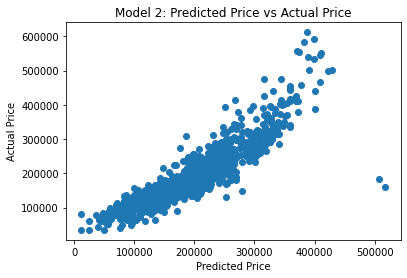

In [31]:
plt.scatter(y_pred_2, y_2_train)
plt.title('Model 2: Predicted Price vs Actual Price')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')

Again, I'll find the metrics:

In [32]:
find_metrics(X_2_train, y_2_train, X_2_test, y_2_test, model_2, y_pred_2)

'MSE: 1131292673.3406951, RMSE: 33634.69448858864, MAE : 21818.28110078169, R2-Train : 0.8173009426259411, R2-Test: 0.8329632261127264, R2 Cross Val: 0.801870476010586'

For this model, I also wanted to see the coefficients of each of the features. Below I'm displaying my list of features and the coefficients:

In [33]:
features_2

['overall_qual',
 'gr_liv_area',
 'garage_cars',
 'garage_area',
 '1st_flr_sf',
 'total_bsmt_sf',
 'year_built',
 'total_bath',
 'year_remod/add',
 'totrms_abvgrd',
 'mas_vnr_area',
 'neighborhood_avg',
 'Bed_bath_ratio']

In [34]:
model_2.coef_

array([ 1.55813992e+04,  2.78852006e+01, -1.27523324e+03,  4.31495452e+01,
        2.01950953e+01,  3.47505597e+00, -1.30715520e+02,  9.64998127e+03,
        2.86730595e+02,  4.84051107e+02,  3.62039763e+01,  3.91723192e+04,
        1.97424242e+03])

Based on the metrics and the coefficients, this model is definitely an improvement but there's still a lot of room for growth.

## Model 3

For the third model, I'm going to include a lot of dummies from categories that I identified in my EDA:

Creating a dummy for house style, exterior quality, basement quality, kitchen quality, and zone:

In [35]:
house_style = pd.get_dummies(ames['house_style'], drop_first=True, prefix='style')
house = list(house_style.columns)

In [36]:
ext_qual = pd.get_dummies(ames['exter_qual'], drop_first=True, prefix='ext')

In [37]:
base_qual = pd.get_dummies(ames['bsmt_qual'], drop_first=True, prefix='base')

In [38]:
kitch_qual = pd.get_dummies(ames['kitchen_qual'], drop_first=True, prefix='kitch')

In [39]:
ms_zone = pd.get_dummies(ames['ms_zoning'], drop_first=True, prefix='zone')

Adding all of the above dummy columsn to my original dataframe:

In [40]:
ames = pd.concat([ames, house_style, ext_qual, base_qual, kitch_qual, ms_zone], axis=1)

Checking that they all were correctly added:

In [41]:
ames

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,base_Gd,base_Po,base_TA,kitch_Fa,kitch_Gd,kitch_TA,zone_FV,zone_RH,zone_RL,zone_RM
0,109,533352170,60,RL,13517,Pave,IR1,Lvl,AllPub,CulDSac,...,0,0,1,0,1,0,0,0,1,0
1,544,531379050,60,RL,11492,Pave,IR1,Lvl,AllPub,CulDSac,...,1,0,0,0,1,0,0,0,1,0
2,153,535304180,20,RL,7922,Pave,Reg,Lvl,AllPub,Inside,...,0,0,1,0,1,0,0,0,1,0
3,318,916386060,60,RL,9802,Pave,Reg,Lvl,AllPub,Inside,...,1,0,0,0,0,1,0,0,1,0
4,255,906425045,50,RL,14235,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,1587,921126030,20,RL,11449,Pave,IR1,HLS,AllPub,Inside,...,1,0,0,0,1,0,0,0,1,0
1965,785,905377130,30,RL,12342,Pave,IR1,Lvl,AllPub,Inside,...,0,0,1,0,0,1,0,0,1,0
1966,916,909253010,50,RL,7558,Pave,Reg,Bnk,AllPub,Inside,...,0,0,1,0,0,1,0,0,1,0
1967,639,535179160,20,RL,10400,Pave,Reg,Lvl,AllPub,Corner,...,0,0,1,0,0,1,0,0,1,0


On to the third pass of my model. First, I'll set up the list of features which includes all the new dummy columns and train test split the data:

Building Model #3:

In [42]:
features_3 = features_2 + list(house_style.columns) + list(ext_qual.columns) + list(base_qual.columns) + list(kitch_qual.columns) + list(ms_zone.columns) 
X_3 = ames[features_3]
y_3 = ames['saleprice']    
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, random_state = 21)   
     
     
     

Instantiating and fitting the model:

In [43]:
model_3 = LinearRegression()

In [44]:
model_3.fit(X_3_train, y_3_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Creating predictions and visualizing them vs the actual price:

In [45]:
y_pred_3 = model_3.predict(X_3_train)

Text(0, 0.5, 'Actual Price')

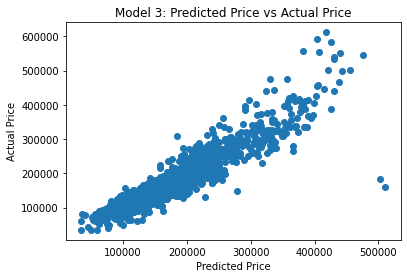

In [46]:
plt.scatter(y_pred_3, y_3_train)
plt.title('Model 3: Predicted Price vs Actual Price')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')

Scoring my model:

In [47]:
find_metrics(X_3_train, y_3_train, X_3_test, y_3_test, model_3, y_pred_3)

'MSE: 941173022.9768827, RMSE: 30678.543364652807, MAE : 19525.189053356124, R2-Train : 0.8480044747253607, R2-Test: 0.8601477280223075, R2 Cross Val: 0.8236602743948991'

Another improvement! However, I have a few more methods I would like to try before submitting this to kaggle.

## Model 4

In this fourth model, I'm going to implement the log for my target and overall quality which had the strongest correlation with price:

Building Model #4:

In [48]:
ames['overall_qual'] = ames['overall_qual'].map(np.log)

features_4 = features_2 + list(house_style.columns) + list(ext_qual.columns) + list(base_qual.columns) + list(kitch_qual.columns) + list(ms_zone.columns) 
X_4 = ames[features_4]
y_4 = ames['saleprice']    
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, random_state = 21)

Splitting the data:

In [49]:
y_4_train_log = np.log(y_4_train)
y_4_test_log = np.log(y_4_test)

Instantiating and fitting the model:

In [50]:
model_4 = LinearRegression()

In [51]:
model_4.fit(X_4_train, y_4_train_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Creating and visualizing the predictions:

In [52]:
y_pred_4_log = model_4.predict(X_4_train)
y_pred_4 = np.exp(y_pred_4_log)

Text(0, 0.5, 'Actual Price')

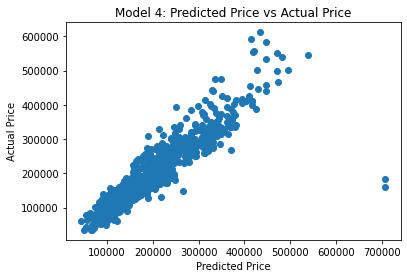

In [53]:
plt.scatter(y_pred_4, y_4_train)
plt.title('Model 4: Predicted Price vs Actual Price')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')

Getting the metrics on this model:

In [54]:
find_metrics_2(X_4_train, y_4_train, X_4_test, y_4_test, model_4, y_pred_4)

'MSE: 1080995477.1378317, RMSE: 32878.49566415458, MAE : 18489.824098823843'

**Note**: At this point, I notice my custom function was not built to handle scoring the models that used log on the target. I created a new function that just does the first three scores while I manually calculated the R2 scores below:

In [55]:
model_4.score(X_4_train, y_4_train_log)

0.8602318546509328

In [56]:
model_4.score(X_4_test, y_4_test_log)

0.8393105243640239

Model 4 is the winner for now, it had a big improvement. Now on to pickling:

In [57]:
pickle.dump(model_4, open('../model/linear_model_4.pkl', 'wb'))

## Model 5

I submitted Model 4 to Kaggle and it did fairly well. Now I'm going to focus on how I can improve that model by looking at the metrics and p-values:

Using statsmodels to look at the p-values:

In [58]:
X_sm = ames[features_4]
y_sm = ames['saleprice']  
X_sm = sm.add_constant(X_sm)
model = sm.OLS(y_sm, X_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     325.2
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:31:26   Log-Likelihood:                -23121.
No. Observations:                1969   AIC:                         4.631e+04
Df Residuals:                    1934   BIC:                         4.651e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3.634e+05   1.24e+05     -2.923      0.004   -6.07e+05    -1.2e+05
overall_qual      5.053e+04   5144.618      9.821      0.000    4.04e+04    6.06e+04
gr_liv_area         52.2394      4.971     10.510      0.000      42.491      61.988
garage_cars       4298.1061   2209.107      1.946      0.052     -34.375    8630.587
garage_area         23.7488      7.636      3.110      0.002       8.772      38.725
1st_flr_sf          -3.1901      6.467     -0.493      0.622     -15.874       9.493
total_bsmt_sf        5.3141      4.163      1.276      0.202      -2.851      13.479
year_built          -3.2462     47.643     -0.068      0.946     -96.684      90.192
total_bath        9544.7371   1786.350      5.343      0.000    6041.363     1.3e+04
year_remod/add     189.1201     50.591      3.738      0.000      89.902     288.338
totrms_abvgrd    -1291.6044    852.017     -1.516      0.130   -2962.573     379.364
mas_vnr_area        19.3887      4.847      4.000      0.000       9.882      28.895
neighborhood_avg  2.766e+04   2044.970     13.526      0.000    2.36e+04    3.17e+04
Bed_bath_ratio    1959.1156   1859.406      1.054      0.292   -1687.535    5605.766
style_1.5Unf      1.787e+04   9468.457      1.887      0.059    -701.366    3.64e+04
style_1Story      9492.9510   3731.209      2.544      0.011    2175.336    1.68e+04
style_2.5Fin     -5564.4029   1.38e+04     -0.403      0.687   -3.26e+04    2.15e+04
style_2.5Unf      6490.8349   8819.946      0.736      0.462   -1.08e+04    2.38e+04
style_2Story     -7324.4010   3074.944     -2.382      0.017   -1.34e+04   -1293.847
style_SFoyer      1.472e+04   5829.271      2.526      0.012    3289.957    2.62e+04
style_SLvl        4295.0805   4499.477      0.955      0.340   -4529.255    1.31e+04
ext_Fa           -3.941e+04   8927.540     -4.414      0.000   -5.69e+04   -2.19e+04
ext_Gd           -3.057e+04   4745.079     -6.442      0.000   -3.99e+04   -2.13e+04
ext_TA           -3.628e+04   5343.030     -6.791      0.000   -4.68e+04   -2.58e+04
base_Fa          -2.789e+04   6004.795     -4.645      0.000   -3.97e+04   -1.61e+04
base_Gd          -2.633e+04   3317.267     -7.938      0.000   -3.28e+04   -1.98e+04
base_Po          -1.273e+04   3.22e+04     -0.396      0.693   -7.59e+04    5.04e+04
base_TA          -2.367e+04   4086.383     -5.792      0.000   -3.17e+04   -1.57e+04
kitch_Fa         -3.893e+04   6475.056     -6.013      0.000   -5.16e+04   -2.62e+04
kitch_Gd         -3.073e+04   3633.699     -8.457      0.000   -3.79e+04   -2.36e+04
kitch_TA         -3.647e+04   4100.199     -8.895      0.000   -4.45e+04   -2.84e+04
zone_FV          -2297.4200   8734.131     -0.263      0.793   -1.94e+04    1.48e+04
zone_RH          -4584.2426   1.13e+04     -0.405      0.686   -2.68e+04    1.76e+04
zone_RL           4358.

According to the p-values above, the following features are not significant in predicting the home price:
- 1st_flr_sf
- total_bsmt_sf
- year_built
- totrms_abvgrd
- Bed_bath_ratio 
- All of the MS Zone categories

In my next pass of the model, I'm going to try removing these or see if there's another way to incorporate them by engineering the feature.

First, I'll do some more EDA to see what other features I should log or create interaction with:

Instead of creating a ratio between beds/baths, I'll create an interaction term:

In [59]:
ames['bed_bath'] = ames['bedroom_abvgr'] * ames['total_bath']

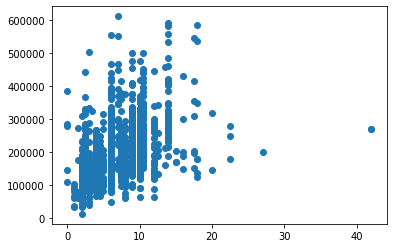

In [60]:
plt.scatter(ames['bed_bath'], ames['saleprice'])

This seems to have a somewhat positive correlation although it isn't very linear. 

In the histograms below, I'm checking out the distribution of sale price and some of the independent variables to see if any are similar. Since I'm taking the log of the target (sale price), it might also be helpful to take the log variables with similar distributions.

(array([ 34., 487., 805., 335., 163.,  77.,  40.,  15.,   6.,   7.]),
 array([ 12789. ,  72675.8, 132562.6, 192449.4, 252336.2, 312223. ,
        372109.8, 431996.6, 491883.4, 551770.2, 611657. ]),
 <a list of 10 Patch objects>)

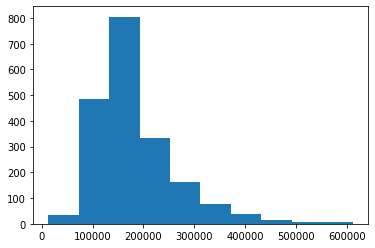

In [61]:
plt.hist(ames['saleprice'])

The sale price is definitely skewed to the left, I'll see if any others match this:

(array([  1.,   5.,  21., 142., 541., 501., 419., 240.,  77.,  22.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

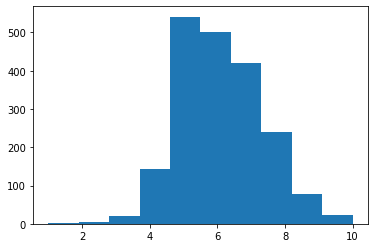

In [62]:
plt.hist(np.exp(ames['overall_qual']))

The ditribution of overall quality if not very skewed.

(array([219., 818., 666., 179.,  71.,  12.,   2.,   0.,   1.,   1.]),
 array([ 438. ,  958.4, 1478.8, 1999.2, 2519.6, 3040. , 3560.4, 4080.8,
        4601.2, 5121.6, 5642. ]),
 <a list of 10 Patch objects>)

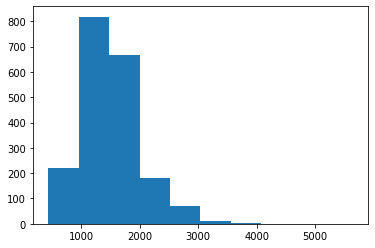

In [63]:
plt.hist(ames['gr_liv_area'])

The feature above has a similar skew to the price distribution, I'll also take the log of this feature:

In [64]:
ames['gr_liv_area_log'] = np.log(ames['gr_liv_area'])

(array([104., 229., 385., 673., 322., 151.,  83.,  10.,   8.,   4.]),
 array([   0. ,  141.8,  283.6,  425.4,  567.2,  709. ,  850.8,  992.6,
        1134.4, 1276.2, 1418. ]),
 <a list of 10 Patch objects>)

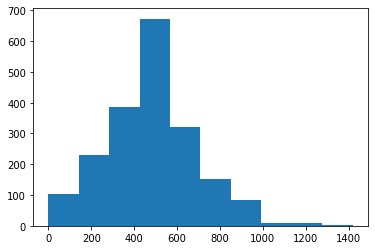

In [65]:
plt.hist(ames['garage_area'])

This distribution for the feature above doesn't match the sale price.

Now I'm going to create a few more scatterplots to see if there are any more relationships I can identify and add to my model.

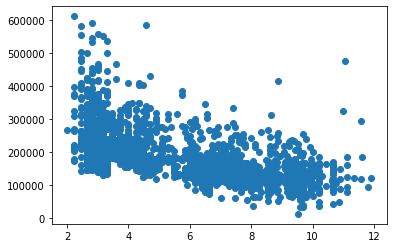

In [66]:
plt.scatter(((2014 - (ames['year_built'])))**.5, 
            ames['saleprice'])

The plot above shows a negative correlation between the square root of the age of the house and price. Below, I'll create a new feature based off this finding:

In [67]:
ames['age_root'] = np.log(2014 - (ames['year_built']))

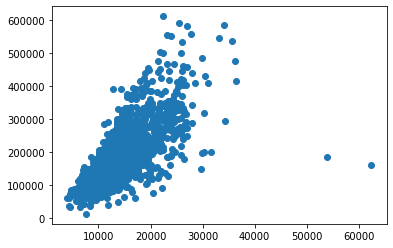

In [68]:
plt.scatter((np.log((ames['lot_area'])))*ames['gr_liv_area'], ames['saleprice'])

The scatter plot above shows a strong positive correlation between the log of the lot area times the living area and sale price. Below, I'll make this into a new feature on my dataframe:

In [69]:
ames['lot_area_log'] = (np.log((ames['lot_area'])))*ames['gr_liv_area']

Since half baths could be considered less valuable, I'm creating a new feature that only looks at the full bathrooms:

In [70]:
ames['only_full_bath'] = ames['bsmt_full_bath'] + ames['full_bath']


I'm also going to try creating a new feature that's the interaction between the year a home was buit and the year it was remodeled squared:

In [71]:
ames['built/remodel'] = ames['year_built'] * ames['year_remod/add']**2

Per the special notes in the data documentation, there was a recommendation to drop two homes that are outliers for square feet to improve the model:

In [72]:
ames[ames['gr_liv_area'] > 5000]

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,zone_FV,zone_RH,zone_RL,zone_RM,bed_bath,gr_liv_area_log,age_root,lot_area_log,only_full_bath,built/remodel
921,1499,908154235,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,0,1,0,13.5,8.637994,1.791759,62428.003179,4.0,8096384512
1808,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,1,0,8.0,8.536015,1.791759,53898.605467,3.0,8104450648


In [73]:
ames.drop(index = [921, 1808], inplace = True)

Building Model #5:

Setting the features and splitting the data:

In [74]:
features_5 = ['overall_qual',
 'garage_area',
 'mas_vnr_area',
 'neighborhood_avg',
 'ext_Fa',
 'ext_Gd',
 'ext_TA',
 'base_Fa',
 'base_Gd',
 'base_TA',
 'kitch_Fa',
 'kitch_Gd',
 'kitch_TA',
 'bed_bath', 
 'gr_liv_area_log',
'built/remodel', 
'only_full_bath',
  'lot_area_log',
'year_remod/add']


In [75]:
X_5 = ames[features_5]
y_5 = ames['saleprice']    
X_5_train, X_5_test, y_5_train, y_5_test = train_test_split(X_5, y_5, random_state = 21)

Taking the log of the target:

In [76]:
y_5_train_log = np.log(y_5_train)
y_5_test_log = np.log(y_5_test)

Instantiating and fitting the model:

In [77]:
model_5 = LinearRegression()

In [78]:
model_5.fit(X_5_train, y_5_train_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Creating and exponetiating the predictions, then creating a plot of the predictions:

In [79]:
y_pred_5_log = model_5.predict(X_5_train)
y_pred_5 = np.exp(y_pred_5_log)

Text(0, 0.5, 'Actual Price')

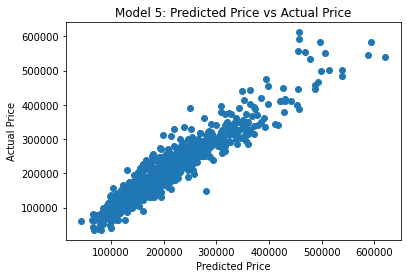

In [80]:
plt.scatter(y_pred_5, y_5_train)
plt.title('Model 5: Predicted Price vs Actual Price')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')

In [81]:
find_metrics_2(X_5_train, y_5_train, X_5_test, y_5_test, model_5, y_pred_5)

'MSE: 579783744.1009636, RMSE: 24078.698970271704, MAE : 16825.619887442142'

In [82]:
model_5.score(X_5_train, y_5_train_log)

0.8804830578171492

In [83]:
model_5.score(X_5_test, y_5_test_log)

0.8291221941059363

In [84]:
X_sm_2 = ames[features_5]
y_sm_2 = ames['saleprice']  
X_sm_2 = sm.add_constant(X_sm_2)
model_sm_2 = sm.OLS(y_sm_2, X_sm_2).fit()
model_sm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     831.2
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:31:27   Log-Likelihood:                -22799.
No. Observations:                1967   AIC:                         4.564e+04
Df Residuals:                    1947   BIC:                         4.575e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8.605e+05    1.3e+05      6.603      0.000    6.05e+05    1.12e+06
overall_qual      5.926e+04   4411.217     13.434      0.000    5.06e+04    6.79e+04
garage_area         29.8309      3.745      7.966      0.000      22.487      37.175
mas_vnr_area        22.9783      4.094      5.613      0.000      14.950      31.007
neighborhood_avg  1.629e+04   1723.058      9.453      0.000    1.29e+04    1.97e+04
ext_Fa           -4.455e+04   7519.967     -5.924      0.000   -5.93e+04   -2.98e+04
ext_Gd           -3.624e+04   4039.481     -8.970      0.000   -4.42e+04   -2.83e+04
ext_TA           -3.985e+04   4542.324     -8.772      0.000   -4.88e+04   -3.09e+04
base_Fa          -2.785e+04   5014.268     -5.554      0.000   -3.77e+04    -1.8e+04
base_Gd          -2.835e+04   2785.018    -10.180      0.000   -3.38e+04   -2.29e+04
base_TA          -2.332e+04   3379.611     -6.900      0.000   -2.99e+04   -1.67e+04
kitch_Fa         -3.521e+04   5533.501     -6.362      0.000   -4.61e+04   -2.44e+04
kitch_Gd         -2.717e+04   3108.076     -8.742      0.000   -3.33e+04   -2.11e+04
kitch_TA         -3.189e+04   3512.490     -9.080      0.000   -3.88e+04    -2.5e+04
bed_bath         -3022.7218    334.277     -9.043      0.000   -3678.301   -2367.143
gr_liv_area_log  -9.844e+04   7389.544    -13.322      0.000   -1.13e+05    -8.4e+04
built/remodel     7.156e-05   9.47e-06      7.554      0.000     5.3e-05    9.01e-05
only_full_bath    1.557e+04   1328.347     11.719      0.000     1.3e+04    1.82e+04
lot_area_log        12.9711      0.506     25.629      0.000      11.978      13.964
year_remod/add    -388.9880     91.019     -4.274      0.000    -567.492    -210.484
==============================================================================
Omnibus:                      330.324   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4924.036
Skew:                           0.292   Prob(JB):                         0.00
Kurtosis:                      10.729   Cond. No.                     1.71e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based off the RMSE, R2, and p-values, this model looks to be an improvement. I'll pickle it and try it out on Kaggle:

In [85]:
pickle.dump(model_5, open('../model/linear_model_5.pkl', 'wb'))

## Model 6

I have a decent score on Kaggle but now I want to just mess around and see what other features I can add to jump the RMSE.

Here are the features from model 5:

In [86]:
print(features_5)

['overall_qual', 'garage_area', 'mas_vnr_area', 'neighborhood_avg', 'ext_Fa', 'ext_Gd', 'ext_TA', 'base_Fa', 'base_Gd', 'base_TA', 'kitch_Fa', 'kitch_Gd', 'kitch_TA', 'bed_bath', 'gr_liv_area_log', 'built/remodel', 'only_full_bath', 'lot_area_log', 'year_remod/add']


Doing some more EDA to find more features to incorporate:

['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'] lot_config
Corner     181918.831325
CulDSac    233659.736000
FR2        176473.928571
FR3        213550.000000
Inside     178822.085754
Name: saleprice, dtype: float64


Text(0, 0.5, 'Average Home Price')

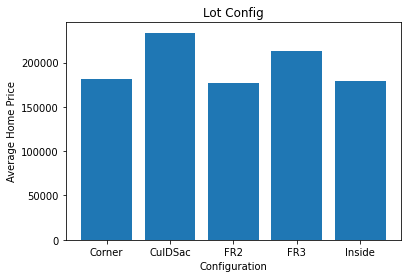

In [87]:
x_lotc = sorted(set(ames['lot_config']))
y_lotc = ames.groupby(ames['lot_config'])['saleprice'].mean()
print(x_lotc, y_lotc)
plt.bar(x_lotc, y_lotc)
plt.title('Lot Config')
plt.xlabel('Configuration')
plt.ylabel('Average Home Price')


This shows some variance in the average home price based on the configuration of the lot. This could be another category to dummy.

Now looking at what condition 1 and 2 mean:

['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe', 'RRNn'] condition_1
Artery    129441.911765
Feedr     143138.163265
Norm      186522.154118
PosA      254733.333333
PosN      254794.296296
RRAe      141070.000000
RRAn      167248.393939
RRNe      129616.666667
RRNn      198208.333333
Name: saleprice, dtype: float64
['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNn'] condition_2
Artery    119050.000000
Feedr     129181.818182
Norm      182831.808346
PosA      390666.666667
PosN      395666.666667
RRAe      190000.000000
RRAn      136905.000000
RRNn       96750.000000
Name: saleprice, dtype: float64


Text(0, 0.5, 'Average Home Price')

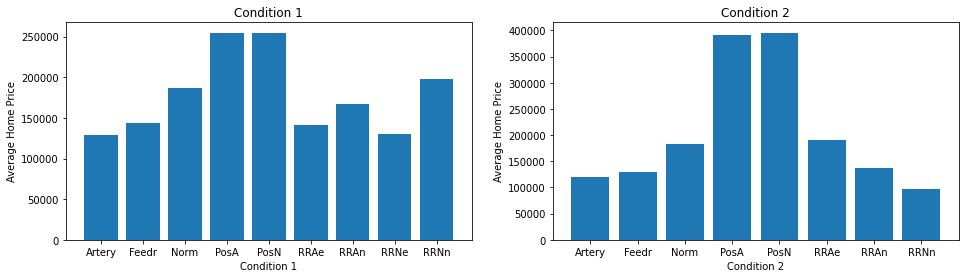

In [88]:
plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
x_cond1 = sorted(set(ames['condition_1']))
y_cond1 = ames.groupby(ames['condition_1'])['saleprice'].mean()
print(x_cond1, y_cond1)
plt.bar(x_cond1, y_cond1)
plt.title('Condition 1')
plt.xlabel('Condition 1')
plt.ylabel('Average Home Price')

plt.subplot(1, 2, 2)
x_cond2 = sorted(set(ames['condition_2']))
y_cond2 = ames.groupby(ames['condition_2'])['saleprice'].mean()
print(x_cond2, y_cond2)
plt.bar(x_cond2, y_cond2)
plt.title('Condition 2')
plt.xlabel('Condition 2')
plt.ylabel('Average Home Price')

Condition 2 has two categories in particular that stick out and could help improve the model.

['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Plywood', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'] exterior_1st
AsbShng    107598.333333
AsphShn     82375.000000
BrkComm    131000.000000
BrkFace    200424.586207
CBlock     105000.000000
CemntBd    244100.988372
HdBoard    160762.470790
ImStucc    262000.000000
MetalSd    156240.447205
Plywood    171277.448276
Stone      258500.000000
Stucco     142968.750000
VinylSd    218940.352941
Wd Sdng    144266.181132
WdShing    155556.390244
Name: saleprice, dtype: float64


Text(0, 0.5, 'Average Home Price')

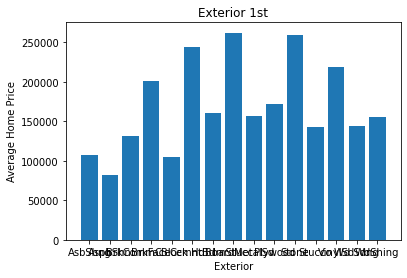

In [89]:
x_ext = sorted(set(ames['exterior_1st']))
y_ext = ames.groupby(ames['exterior_1st'])['saleprice'].mean()
print(x_ext, y_ext)
plt.bar(x_ext, y_ext)
plt.title('Exterior 1st')
plt.xlabel('Exterior')
plt.ylabel('Average Home Price')

The plot above looks at the types of exterior on the house. There are several cateogires that jump out as having high average prices. Again, this could be useful in predicting the price.

['BrkTil', 'CBlock', 'PConc', 'Stone', 'Wood'] foundation
BrkTil    129722.714286
CBlock    148855.992925
PConc     228300.344134
Stone     143235.200000
Wood      173750.000000
Name: saleprice, dtype: float64


Text(0, 0.5, 'Average Home Price')

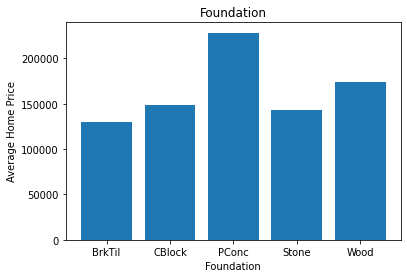

In [90]:
x_found = sorted(set(ames['foundation']))
y_found = ames.groupby(ames['foundation'])['saleprice'].mean()
print(x_found, y_found)
plt.bar(x_found, y_found)
plt.title('Foundation')
plt.xlabel('Foundation')
plt.ylabel('Average Home Price')

Poured concrete has a higher average than all the other types of foundation. I'll include this feature in my next model.

['GasA', 'GasW', 'Grav', 'OthW'] heating
GasA    183592.420103
GasW    151275.000000
Grav     65180.000000
OthW    125750.000000
Name: saleprice, dtype: float64
['N', 'Y'] central_air
N    104845.563025
Y    187930.504870
Name: saleprice, dtype: float64
['Ex', 'Fa', 'Gd', 'Po', 'TA'] heating_qc
Ex    216346.633981
Fa    123598.033898
Gd    160812.528846
Po     97000.000000
TA    140559.164894
Name: saleprice, dtype: float64


Text(0, 0.5, 'Average Home Price')

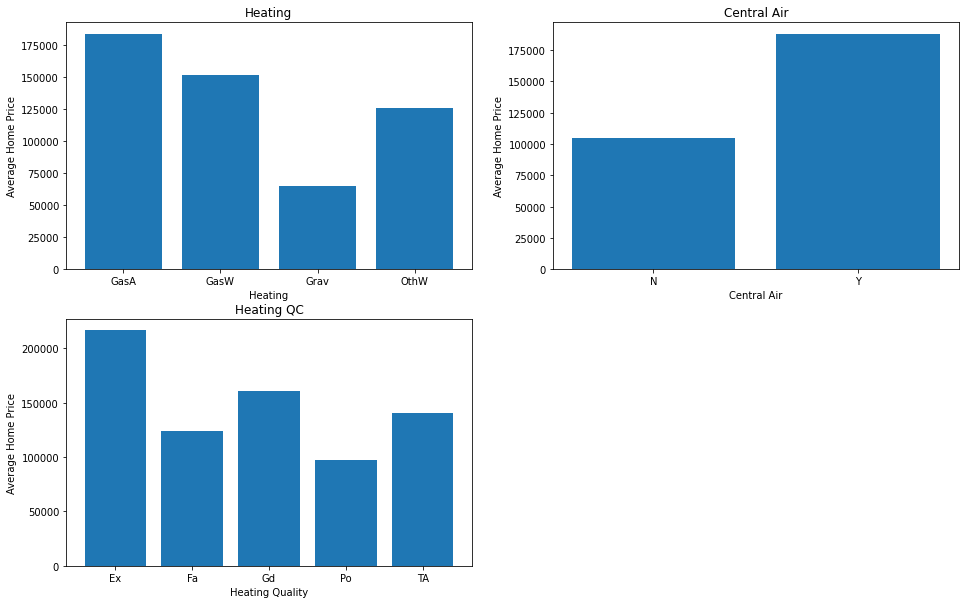

In [91]:
plt.figure(figsize=(16,10))

plt.subplot(2, 2, 1)
x_heat = sorted(set(ames['heating']))
y_heat = ames.groupby(ames['heating'])['saleprice'].mean()
print(x_heat, y_heat)
plt.bar(x_heat, y_heat)
plt.title('Heating')
plt.xlabel('Heating')
plt.ylabel('Average Home Price')

plt.subplot(2, 2, 2)
x_ca = sorted(set(ames['central_air']))
y_ca = ames.groupby(ames['central_air'])['saleprice'].mean()
print(x_ca, y_ca)
plt.bar(x_ca, y_ca)
plt.title('Central Air')
plt.xlabel('Central Air')
plt.ylabel('Average Home Price')

plt.subplot(2, 2, 3)
x_qc = sorted(set(ames['heating_qc']))
y_qc = ames.groupby(ames['heating_qc'])['saleprice'].mean()
print(x_qc, y_qc)
plt.bar(x_qc, y_qc)
plt.title('Heating QC')
plt.xlabel('Heating Quality')
plt.ylabel('Average Home Price')

The plots above look at heating and central air. There seems to be a big difference in houses that do have central air vs those who don't as well as the quality of the heating system.

['N', 'P', 'Y'] paved_drive
N    108719.515385
P    128733.891892
Y    189375.280000
Name: saleprice, dtype: float64


Text(0, 0.5, 'Average Home Price')

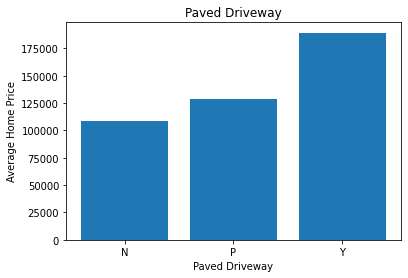

In [92]:

x_drive = sorted(set(ames['paved_drive']))
y_drive = ames.groupby(ames['paved_drive'])['saleprice'].mean()
print(x_drive, y_drive)
plt.bar(x_drive, y_drive)
plt.title('Paved Driveway');
plt.xlabel('Paved Driveway')
plt.ylabel('Average Home Price')

The graph above shows the distinction between having a paved driveway or not. Those who had one on average had a more expensive house.

Next, I'm going to look at the outdoor areas such as deck and porches.

In [93]:
ames['porch/deck'] = (np.log(1 + ames['wood_deck_sf'] + ames['open_porch_sf'] + ames['enclosed_porch'] + ames['3ssn_porch'] + ames['screen_porch']))**2

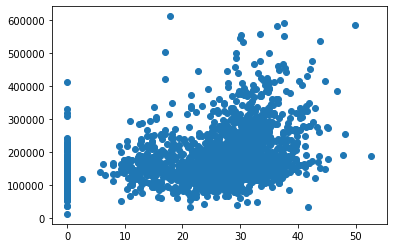

In [94]:
plt.scatter(ames['porch/deck'], ames['saleprice'])

After running the plot above a few times, it looks like taking the natrual log of the porch/deck created somewhat of a correlation (although it is largely centered). For now, I'll move forward with this feature to see what impact it has.

For this next pass, I'm going to dummy quite a few columns but using different techniques. For Central Air, Heating, and Heating QC I'm just going to make straight up dummy columns. For Condition 2, Exterior 1st, Foundation, and MS Sub, I'm going to use the strategy I did with neighborhoods and dummy in one column based on the average price for that category:

Converting Condition 2:

In [95]:
cond2_avg = ames.groupby(ames['condition_2'])['saleprice'].mean()

print(cond2_avg)

condition_2
Artery    119050.000000
Feedr     129181.818182
Norm      182831.808346
PosA      390666.666667
PosN      395666.666667
RRAe      190000.000000
RRAn      136905.000000
RRNn       96750.000000
Name: saleprice, dtype: float64


In [96]:
condition2 = list(ames['condition_2'].unique())

In [97]:
condition2 = sorted(condition2)

In [98]:
cond_dict = {condition : round((avg/10_0000), 2) 
               for(condition, avg) in zip(condition2, cond2_avg)}

In [99]:
print(cond_dict)

{'Artery': 1.19, 'Feedr': 1.29, 'Norm': 1.83, 'PosA': 3.91, 'PosN': 3.96, 'RRAe': 1.9, 'RRAn': 1.37, 'RRNn': 0.97}


In [100]:
#Adapted from Daniel Kim's potato example

ames['condition2_avg'] = ames['condition_2'].apply(lambda x: cond_dict[x])

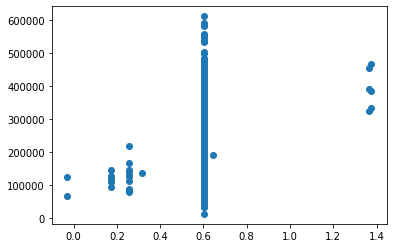

In [101]:
plt.scatter(np.log(ames['condition2_avg']), ames['saleprice'])

Conversting Exterior 1st:

In [102]:
ext1_avg = ames.groupby(ames['exterior_1st'])['saleprice'].mean()

print(ext1_avg)

exterior_1st
AsbShng    107598.333333
AsphShn     82375.000000
BrkComm    131000.000000
BrkFace    200424.586207
CBlock     105000.000000
CemntBd    244100.988372
HdBoard    160762.470790
ImStucc    262000.000000
MetalSd    156240.447205
Plywood    171277.448276
Stone      258500.000000
Stucco     142968.750000
VinylSd    218940.352941
Wd Sdng    144266.181132
WdShing    155556.390244
Name: saleprice, dtype: float64


In [103]:
exterior = list(ames['exterior_1st'].unique())
exterior = sorted(exterior)

In [104]:
ext_dict = {ext : round((avg/10_0000), 2) 
               for(ext, avg) in zip(exterior, ext1_avg)}
print(ext_dict)

{'AsbShng': 1.08, 'AsphShn': 0.82, 'BrkComm': 1.31, 'BrkFace': 2.0, 'CBlock': 1.05, 'CemntBd': 2.44, 'HdBoard': 1.61, 'ImStucc': 2.62, 'MetalSd': 1.56, 'Plywood': 1.71, 'Stone': 2.58, 'Stucco': 1.43, 'VinylSd': 2.19, 'Wd Sdng': 1.44, 'WdShing': 1.56}


In [105]:
ames['exterior_avg'] = ames['exterior_1st'].apply(lambda x: ext_dict[x])

Converting Foundation:

In [106]:
found_avg = ames.groupby(ames['foundation'])['saleprice'].mean()

print(found_avg)

foundation
BrkTil    129722.714286
CBlock    148855.992925
PConc     228300.344134
Stone     143235.200000
Wood      173750.000000
Name: saleprice, dtype: float64


In [107]:
found = list(ames['foundation'].unique())
found = sorted(found)

In [108]:
found_dict = {f : round((avg/10_0000), 2) 
               for(f, avg) in zip(found, found_avg)}
print(found_dict)

{'BrkTil': 1.3, 'CBlock': 1.49, 'PConc': 2.28, 'Stone': 1.43, 'Wood': 1.74}


In [109]:
ames['foundation_avg'] = ames['foundation'].apply(lambda x: found_dict[x])

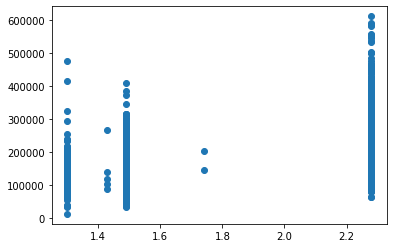

In [110]:
plt.scatter(ames['foundation_avg'], ames['saleprice'])

Converting MS Subclass:

In [111]:
ms_avg = ames.groupby(ames['ms_subclass'])['saleprice'].mean()

print(ms_avg)

ms_subclass
20     190648.312076
30      96256.389474
40     119125.000000
45     116372.727273
50     137840.635897
60     239862.186352
70     153636.272727
75     204875.000000
80     169617.705882
85     152764.814815
90     151622.745455
120    211798.426357
150    148400.000000
160    138452.215909
180    109672.727273
190    126296.022727
Name: saleprice, dtype: float64


In [112]:
ms_sub = list(ames['ms_subclass'].unique())
ms_sub = sorted(ms_sub)

In [113]:
ms_dict = {subclass : round((avg/10_0000), 2) 
               for(subclass, avg) in zip(ms_sub, ms_avg)}
print(ms_dict)

{20: 1.91, 30: 0.96, 40: 1.19, 45: 1.16, 50: 1.38, 60: 2.4, 70: 1.54, 75: 2.05, 80: 1.7, 85: 1.53, 90: 1.52, 120: 2.12, 150: 1.48, 160: 1.38, 180: 1.1, 190: 1.26}


In [114]:
ames['ms_avg'] = ames['ms_subclass'].apply(lambda x: ms_dict[x])

In [115]:
ames['ms_log'] = np.log(ames['ms_avg'])

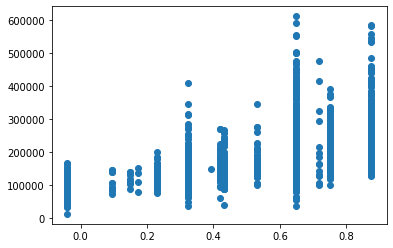

In [116]:
plt.scatter(np.log(ames['ms_avg']), ames['saleprice'])

Now creating the regular dummies:

Central Air

In [117]:
cent_air = pd.get_dummies(ames['central_air'], drop_first=True, prefix='CA')

In [118]:
ames.head()

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,age_root,lot_area_log,only_full_bath,built/remodel,porch/deck,condition2_avg,exterior_avg,foundation_avg,ms_avg,ms_log
0,109,533352170,60,RL,13517,Pave,IR1,Lvl,AllPub,CulDSac,...,3.637586,14067.809375,2.0,7943569400,14.490679,1.83,1.61,1.49,2.40,0.875469
1,544,531379050,60,RL,11492,Pave,IR1,Lvl,AllPub,CulDSac,...,2.890372,19839.440423,3.0,7960065964,18.640704,1.83,2.19,2.28,2.40,0.875469
2,153,535304180,20,RL,7922,Pave,Reg,Lvl,AllPub,Inside,...,4.110874,9489.110720,2.0,7866779697,15.763218,1.83,2.19,1.49,1.91,0.647103
3,318,916386060,60,RL,9802,Pave,Reg,Lvl,AllPub,Inside,...,2.079442,13270.853452,2.0,8080266294,21.299337,1.83,2.19,2.28,2.40,0.875469
4,255,906425045,50,RL,14235,Pave,IR1,Lvl,AllPub,Inside,...,4.736198,13819.198255,2.0,7546893100,16.763657,1.83,1.44,2.28,1.38,0.322083


Heating

In [119]:
heat_dummy = pd.get_dummies(ames['heating'], drop_first=True, prefix='heat')

Heating QC

In [120]:
heat_qc = pd.get_dummies(ames['heating_qc'], drop_first=True, prefix='heatqc')

In [121]:
drive = pd.get_dummies(ames['paved_drive'], drop_first=True, prefix='drive')

In [122]:
ames = pd.concat([ames, cent_air, heat_dummy, heat_qc, drive], axis=1)

Building Model #6:

Setting the new features and splitting the data:

In [123]:
features_6 = ['overall_qual',
 'garage_area',
 'mas_vnr_area',
 'neighborhood_avg',
 'ext_Fa',
 'ext_Gd',
 'ext_TA',
 'base_Fa',
 'base_Gd',
 'base_TA',
 'kitch_Fa',
 'kitch_Gd',
 'kitch_TA',
 'bed_bath',
 'gr_liv_area_log',
 'built/remodel',
 'only_full_bath',
 'lot_area_log',
 'year_remod/add',
 'exterior_avg',
'porch/deck',
 'drive_Y',
 'CA_Y',
 'heat_Grav',
 'heatqc_TA']

In [124]:
X_6 = ames[features_6]
y_6 = ames['saleprice']    
X_6_train, X_6_test, y_6_train, y_6_test = train_test_split(X_6, y_6, random_state = 21)

Taking the log of the target:

In [125]:
y_6_train_log = np.log(y_6_train)
y_6_test_log = np.log(y_6_test)

Instantiating and fitting the model:

In [126]:
model_6 = LinearRegression()

In [127]:
model_6.fit(X_6_train, y_6_train_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Creating predictions and a plot for the predictions:

In [128]:
y_pred_6_log = model_6.predict(X_6_train)
y_pred_6 = np.exp(y_pred_6_log)

Text(0, 0.5, 'Actual Price')

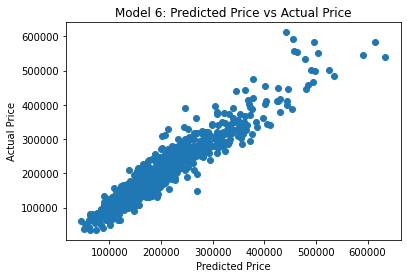

In [129]:
plt.scatter(y_pred_6, y_6_train)
plt.title('Model 6: Predicted Price vs Actual Price')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')

Scoring the model:

In [130]:
find_metrics_2(X_6_train, y_6_train, X_6_test, y_6_test, model_6, y_pred_6)

'MSE: 555321236.4417259, RMSE: 23565.254856286316, MAE : 16183.696893799803'

In [131]:
model_6.score(X_6_train, y_6_train_log)

0.8935133627322086

In [132]:
model_6.score(X_6_test, y_6_test_log)

0.8534327055546604

In [133]:
X_sm_3 = ames[features_6]
y_sm_3 = ames['saleprice']  
X_sm_3 = sm.add_constant(X_sm_3)
model_sm_3 = sm.OLS(y_sm_3, X_sm_3).fit()
model_sm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     657.7
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:31:29   Log-Likelihood:                -22761.
No. Observations:                1967   AIC:                         4.557e+04
Df Residuals:                    1941   BIC:                         4.572e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8.265e+05   1.34e+05      6.147      0.000    5.63e+05    1.09e+06
overall_qual      5.594e+04   4365.727     12.814      0.000    4.74e+04    6.45e+04
garage_area         26.4870      3.710      7.139      0.000      19.211      33.763
mas_vnr_area        24.3965      4.041      6.037      0.000      16.472      32.321
neighborhood_avg  1.673e+04   1697.104      9.856      0.000    1.34e+04    2.01e+04
ext_Fa           -4.263e+04   7447.743     -5.723      0.000   -5.72e+04    -2.8e+04
ext_Gd            -3.63e+04   3969.662     -9.145      0.000   -4.41e+04   -2.85e+04
ext_TA           -4.025e+04   4488.650     -8.966      0.000    -4.9e+04   -3.14e+04
base_Fa          -2.701e+04   4962.113     -5.444      0.000   -3.67e+04   -1.73e+04
base_Gd          -2.833e+04   2745.249    -10.321      0.000   -3.37e+04    -2.3e+04
base_TA          -2.306e+04   3361.349     -6.861      0.000   -2.97e+04   -1.65e+04
kitch_Fa         -3.029e+04   5507.717     -5.500      0.000   -4.11e+04   -1.95e+04
kitch_Gd         -2.736e+04   3057.381     -8.949      0.000   -3.34e+04   -2.14e+04
kitch_TA         -3.116e+04   3457.784     -9.010      0.000   -3.79e+04   -2.44e+04
bed_bath         -2922.9799    330.249     -8.851      0.000   -3570.661   -2275.299
gr_liv_area_log  -1.022e+05   7287.556    -14.025      0.000   -1.16e+05   -8.79e+04
built/remodel     5.111e-05   1.05e-05      4.851      0.000    3.04e-05    7.18e-05
only_full_bath    1.558e+04   1321.478     11.788      0.000     1.3e+04    1.82e+04
lot_area_log        12.9725      0.500     25.960      0.000      11.992      13.953
year_remod/add    -291.9590     96.989     -3.010      0.003    -482.172    -101.746
exterior_avg      6537.0720   2245.649      2.911      0.004    2132.935    1.09e+04
porch/deck         252.4471     54.270      4.652      0.000     146.014     358.880
drive_Y           9471.7205   2467.943      3.838      0.000    4631.624    1.43e+04
CA_Y              8611.8745   2805.321      3.070      0.002    3110.116    1.41e+04
heat_Grav        -2.767e+04   1.21e+04     -2.288      0.022   -5.14e+04   -3955.769
heatqc_TA        -4208.1831   1509.323     -2.788      0.005   -7168.248   -1248.119
==============================================================================
Omnibus:                      358.261   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5489.038
Skew:                           0.381   Prob(JB):                         0.00
Kurtosis:                      11.148   Cond. No.                     1.79e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+

Another improvement so pickeling to try on Kaggle:

In [134]:
pickle.dump(model_6, open('../model/model_6.pkl', 'wb'))

To give my test r2 score a boost, I'm going to try lasso with these features:

Importing LASSO:

In [135]:
from sklearn.linear_model import LassoCV

Setting my features and splitting the data:

In [136]:
X_6_L = ames[features_6]
y_6_L = ames['saleprice']

In [137]:
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_6_L, y_6_L, random_state = 21)

To use LASSO, I'll need to scale my data:

Instantiating and fitting the scaler:

In [138]:
ss = StandardScaler()
ss.fit(X_l_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

Scaling the data:

In [139]:
Z_train = ss.transform(X_l_train)
Z_test = ss.transform(X_l_test)

Setting the alphas, instantiating and fitting the model:

In [140]:
alpha_l = np.logspace(-3, 3, 100)
lasso_model = LassoCV(
    alphas = alpha_l,
    cv = 5
)

In [141]:
lasso_model.fit(Z_train, y_l_train);

Creating predictions:

In [142]:
predictions = lasso_model.predict(Z_train)

Scoring the model:

In [143]:
find_metrics_2(X_l_train, y_l_train, X_l_test, y_l_test, lasso_model, predictions)

'MSE: 629573690.5365498, RMSE: 25091.307071106316, MAE : 17393.777023225102'

In [144]:
print(lasso_model.score(Z_train, y_l_train))
print(lasso_model.score(Z_test, y_l_test))

0.898136230834737
0.8791049882093581


I'll also pickle this one to try it out on Kaggle:

In [145]:
pickle.dump(lasso_model, open('../model/lasso_model_6.pkl', 'wb'))

Pickling the scaler too...

In [146]:
pickle.dump(ss, open('../assets/standard_scaler_6.pkl', 'wb'))

## Model 7

For my final model, I'm going to revisit some of the categories I created dummies for. Instead of creating separate columns I'm going to either assign it a value 1-5 if it's a quality or condition category or (similar to what I did with neighborhoods) assign it a value based on the average home price for that category:

Creating dummy for kitchen quality:

In [147]:
kitchens = list(ames['kitchen_qual'].unique())
kitchens = sorted(kitchens)

In [148]:
print(kitchens)

['Ex', 'Fa', 'Gd', 'TA']


In [149]:
kitchen_list = [5, 2, 4, 3]

In [150]:
kitchen_dict = {kitchen : num 
               for(kitchen, num) in zip(kitchens, kitchen_list)}
print(kitchen_dict)

{'Ex': 5, 'Fa': 2, 'Gd': 4, 'TA': 3}


In [151]:
#Adapted from Daniel Kim's potato example

ames['kitchen_score'] = ames['kitchen_qual'].apply(lambda x: kitchen_dict[x])

Creating dummy for basement quality:

In [152]:
basements = list(ames['bsmt_qual'].unique())
basements = sorted(basements)

In [153]:
print(basements)

['Ex', 'Fa', 'Gd', 'Po', 'TA']


In [154]:
bsmt_list = [5, 2, 4, 1, 3]

In [155]:
bsmt_dict = {basement : num 
               for(basement, num) in zip(basements, bsmt_list)}
print(bsmt_dict)

{'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1, 'TA': 3}


In [156]:
ames['basement_score'] = ames['bsmt_qual'].apply(lambda x: bsmt_dict[x])

Creating dummy for exterior quality:

In [157]:
exts = list(ames['exter_qual'].unique())
exts = sorted(exts)

In [158]:
print(exts)

['Ex', 'Fa', 'Gd', 'TA']


In [159]:
ext_list = [5, 2, 4, 3]

In [160]:
ext_dict = {ext : num 
               for(ext, num) in zip(exts, ext_list)}
print(ext_dict)

{'Ex': 5, 'Fa': 2, 'Gd': 4, 'TA': 3}


In [161]:
ames['ext_score'] = ames['exter_qual'].apply(lambda x: ext_dict[x])

Creating dummy for lot_config types:

In [162]:
ames.groupby('lot_config')['saleprice'].mean().sort_values()

lot_config
FR2        176473.928571
Inside     178822.085754
Corner     181918.831325
FR3        213550.000000
CulDSac    233659.736000
Name: saleprice, dtype: float64

In [163]:
lot_dict = {'FR2':1.7, 'Inside': 1.7, 'Corner':1.8, 'FR3': 2.3, 'CulDSac':2.3 }
ames['lot_config_score'] = ames['lot_config'].apply(lambda x: lot_dict[x])

Creating dummy for utilities types:

In [164]:
ames.groupby('utilities')['saleprice'].mean().sort_values()

utilities
NoSeWa    137500.000000
AllPub    182927.108342
Name: saleprice, dtype: float64

In [165]:
uti_dict = {'NoSeWa':0, 'AllPub':1 }
ames['utilities_score'] = ames['utilities'].apply(lambda x: uti_dict[x])

Creating dummy for land contour types:

In [166]:
ames.groupby('land_contour')['saleprice'].mean().sort_values()

land_contour
Bnk    143286.675676
Lvl    180160.022612
Low    210829.100000
HLS    262294.488095
Name: saleprice, dtype: float64

In [167]:
land_dict = {'Bnk': 1.4, 'Lvl': 1.8, 'Low':2, 'HLS': 2.6 }
ames['contour_score'] = ames['land_contour'].apply(lambda x: land_dict[x])

Creating dummy for roof style types:

In [168]:
ames.groupby('roof_style')['saleprice'].mean().sort_values()

roof_style
Gambrel    138208.333333
Mansard    152642.857143
Gable      172576.343042
Flat       191613.076923
Shed       208666.666667
Hip        225575.645995
Name: saleprice, dtype: float64

In [169]:
roof_dict = {'Gambrel': 1.3, 'Mansard': 1.5, 'Gable': 1.7, 'Flat': 1.9, 'Shed': 2, 'Hip': 2.3}
ames['roof_score'] = ames['roof_style'].apply(lambda x: roof_dict[x])

Creating dummy for foundation types:

In [170]:
ames.groupby('foundation')['saleprice'].mean().sort_values()

foundation
BrkTil    129722.714286
Stone     143235.200000
CBlock    148855.992925
Wood      173750.000000
PConc     228300.344134
Name: saleprice, dtype: float64

In [171]:
found_dict = {'BrkTil': 1.3, 'Stone': 1.4, 'CBlock': 1.4, 'Wood': 1.7, 'PConc': 2.3}
ames['found_score'] = ames['foundation'].apply(lambda x: found_dict[x])

Creating dummy for electrical types:

In [172]:
ames.groupby('electrical')['saleprice'].mean().sort_values()

electrical
Mix       67000.000000
FuseP     83733.333333
FuseF    108377.214286
FuseA    125982.398438
SBrkr    188493.617517
Name: saleprice, dtype: float64

In [173]:
elc_dict = {'Mix': .5, 'FuseP': .5, 'FuseF': 1, 'FuseA': 1, 'SBrkr': 2}
ames['elec_score'] = ames['electrical'].apply(lambda x: elc_dict[x])

Creating dummy for street types:

In [174]:
ames.groupby('street')['saleprice'].mean().sort_values()

street
Grvl     91780.833333
Pave    183182.819990
Name: saleprice, dtype: float64

In [175]:
street_dict = {'Grvl': 0, 'Pave': 1}
ames['street_score'] = ames['street'].apply(lambda x: street_dict[x])

Creating dummy for condition_1 types:

In [176]:
ames.groupby('condition_1')['saleprice'].mean().sort_values()

condition_1
Artery    129441.911765
RRNe      129616.666667
RRAe      141070.000000
Feedr     143138.163265
RRAn      167248.393939
Norm      186522.154118
RRNn      198208.333333
PosA      254733.333333
PosN      254794.296296
Name: saleprice, dtype: float64

Creating dummy for condition_2 types:

In [177]:
ames.groupby('condition_2')['saleprice'].mean().sort_values()

condition_2
RRNn       96750.000000
Artery    119050.000000
Feedr     129181.818182
RRAn      136905.000000
Norm      182831.808346
RRAe      190000.000000
PosA      390666.666667
PosN      395666.666667
Name: saleprice, dtype: float64

In [178]:
cond2_dict = {'RRNn': .9, 'Artery': 1.2, 'Feedr': 1.3, 'RRAn': 1.3, 'Norm': 1.8, 'RRAe': 1.9, 'PosA': 3.9, 'PosN': 3.9}
ames['cond2_score'] = ames['condition_2'].apply(lambda x: cond2_dict[x])


Creating dummy for masonry veneer types:

In [179]:
ames.groupby('mas_vnr_type')['saleprice'].mean().sort_values()

mas_vnr_type
BrkCmn     149683.666667
None       155725.528302
BrkFace    212583.956661
Stone      264820.602410
Name: saleprice, dtype: float64

In [180]:
mas_dict = {'BrkCmn': 1.5, 'None':1.5, 'BrkFace':2, 'Stone': 2.6}
ames['mas_score'] = ames['mas_vnr_type'].apply(lambda x: mas_dict[x])

Creating dummy for fireplaces:

In [181]:
ames.groupby('fireplaces')['saleprice'].mean().sort_values()

fireplaces
0    143693.221987
1    215567.888889
2    240414.014085
3    249770.000000
4    260000.000000
Name: saleprice, dtype: float64

In [182]:
fire_dict = {0:0, 1:1, 2:1, 3:1, 4:1}
ames['fire'] = ames['fireplaces'].apply(lambda x: fire_dict[x])

Creating dummy for sale type types:

In [183]:
ames.groupby('sale_type')['saleprice'].mean().sort_values()

sale_type
ConLw    124600.000000
Oth      127497.750000
COD      133696.693548
ConLD    139302.333333
WD       176620.115317
CWD      186635.000000
ConLI    207992.857143
Con      241807.500000
New      281726.801370
Name: saleprice, dtype: float64

In [184]:
saletype_dict = {'ConLw': 1.2, 'Oth': 1.2, 'COD': 1.3, 'ConLD': 1.4, 
                 'WD ': 1.7, 'CWD': 1.8, 'ConLI': 2, 'Con': 2.4, 'New': 2.8}
ames['sale_score'] = ames['sale_type'].apply(lambda x: saletype_dict[x])




Creating dummy for building types:

In [185]:
ames.groupby('bldg_type')['saleprice'].mean().sort_values()

bldg_type
2fmCon    125114.204545
Twnhs     133100.000000
Duplex    151622.745455
1Fam      186138.407678
TwnhsE    198043.620253
Name: saleprice, dtype: float64

In [186]:
bldg_dict = {'2fmCon':1.2, 'Twnhs':1.3, 'Duplex': 1.5, '1Fam': 1.8, 'TwnhsE': 1.9}
ames['bldg_score'] = ames['bldg_type'].apply(lambda x: bldg_dict[x])

Building Model #7:

In [187]:
features_7 = ['overall_qual',
 'garage_area',
 'mas_vnr_area',
 'neighborhood_avg',
 'bed_bath',
 'gr_liv_area',
 'built/remodel',
 'lot_area_log',
'porch/deck',
 'kitchen_score',
'basement_score',
'ext_score',
'bsmtfin_sf_1',
'total_bsmt_sf',
'overall_cond',      
'lot_area',    
'contour_score', 
'roof_score', 
'found_score',         
'cond2_score',
'fire',
'sale_score']


In [188]:
X_7 = ames[features_7]
y_7 = ames['saleprice']

In [189]:
X_7_train, X_7_test, y_7_train, y_7_test = train_test_split(X_7, y_7, random_state = 21)

In [190]:
y_7_train_log = np.log(y_7_train)
y_7_test_log = np.log(y_7_test)

Instantiating and fitting the model:

In [191]:
model_7 = LinearRegression()

In [192]:
model_7.fit(X_7_train, y_7_train_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Creating predictions and visualizing the results:

In [193]:
y_pred_7_log = model_7.predict(X_7_train)
y_pred_7 = np.exp(y_pred_7_log)

Text(0, 0.5, 'Actual Price')

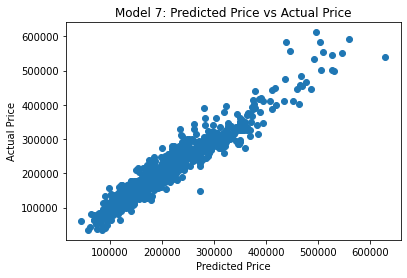

In [194]:
plt.scatter(y_pred_7, y_7_train)
plt.title('Model 7: Predicted Price vs Actual Price')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')

Score the model:

In [195]:
find_metrics_2(X_7_train, y_7_train, X_7_test, y_7_test, model_7, y_pred_7)

'MSE: 434523818.6174986, RMSE: 20845.23491394373, MAE : 14593.29179273477'

In [196]:
model_7.score(X_7_train, y_7_train_log)

0.9089102564290833

In [197]:
model_7.score(X_7_test, y_7_test_log)

0.880691898266243

In [198]:
X_sm_4 = ames[features_7]
y_sm_4 = ames['saleprice']  
X_sm_4 = sm.add_constant(X_sm_4)
model_sm_4 = sm.OLS(y_sm_4, X_sm_4).fit()
model_sm_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     783.6
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:31:30   Log-Likelihood:                -22721.
No. Observations:                1967   AIC:                         4.549e+04
Df Residuals:                    1944   BIC:                         4.562e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3.344e+05      3e+04    -11.157      0.000   -3.93e+05   -2.76e+05
overall_qual      3.447e+04   4260.526      8.090      0.000    2.61e+04    4.28e+04
garage_area         19.3724      3.634      5.330      0.000      12.245      26.500
mas_vnr_area        30.8492      3.925      7.860      0.000      23.152      38.546
neighborhood_avg   1.74e+04   1649.003     10.554      0.000    1.42e+04    2.06e+04
bed_bath          -655.2880    253.645     -2.583      0.010   -1152.734    -157.842
gr_liv_area        -89.6462     13.714     -6.537      0.000    -116.542     -62.750
built/remodel     6.581e-06   4.22e-06      1.561      0.119   -1.69e-06    1.48e-05
lot_area_log        15.1498      1.443     10.500      0.000      12.320      17.979
porch/deck         105.5903     52.945      1.994      0.046       1.755     209.425
kitchen_score     9373.6477   1386.826      6.759      0.000    6653.824    1.21e+04
basement_score    8825.1889   1418.230      6.223      0.000    6043.777    1.16e+04
ext_score         1.308e+04   1742.505      7.505      0.000    9660.383    1.65e+04
bsmtfin_sf_1        24.0941      1.609     14.973      0.000      20.938      27.250
total_bsmt_sf       20.2654      2.120      9.560      0.000      16.108      24.423
overall_cond      5184.7517    587.130      8.831      0.000    4033.281    6336.222
lot_area            -0.4335      0.151     -2.862      0.004      -0.731      -0.136
contour_score     1.875e+04   3220.564      5.821      0.000    1.24e+04    2.51e+04
roof_score        1.132e+04   2560.032      4.421      0.000    6298.200    1.63e+04
found_score       5238.5720   1991.421      2.631      0.009    1333.028    9144.116
cond2_score       1.171e+04   4515.557      2.594      0.010    2857.955    2.06e+04
fire              5073.2489   1361.246      3.727      0.000    2403.594    7742.904
sale_score        1.952e+04   2097.400      9.309      0.000    1.54e+04    2.36e+04
==============================================================================
Omnibus:                      433.634   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5554.978
Skew:                           0.661   Prob(JB):                         0.00
Kurtosis:                      11.126   Cond. No.                     4.09e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.09e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This one is the best yet so pickling to try it out with the Kaggle data:

In [199]:
pickle.dump(model_7, open('../model/linear_model_7.pkl', 'wb'))